# CNN-lytical Assignment-1
*  In this assignment, we will build a classifier for MNIST from scratch using just [NumPy](https://numpy.org/)

*  [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits of size 28x28

*  The dataset that you are expected to use for training can be found [here](https://drive.google.com/file/d/1z7lwIml6UxsNpDIW3_mPPEb8SoaPC5Zg/view)

*   Our model will have 1 hidden layer, like the one below (not our recommendation to use 256 in the hidden layer though, try various values out)

**Feel free to redefine any function signatures below, just make sure the final cell remains the same.**

<center>
<img src="https://user-images.githubusercontent.com/81357954/166119893-4ca347b8-b1a4-40b8-9e0a-2e92b5f164ae.png">
</center>

## Import libraries here
NumPy, Matplotlib, ...

Also remember to initialize the seed for reproducibility of results

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(23)

## Load *Dataset*
Load data from the given pickle file

In [2]:
# mount Google Drive to access the dataset
# normalize
# Split into X_train, y_train, X_test, y_test
# you can use stratified splitting from sklearn library
# load the data set

from google.colab import drive
drive.mount('/content/gdrive')

df = pd.read_pickle('/content/gdrive/MyDrive/CNN-lytical/Week 2/train_data.pkl')
data = pd.DataFrame(df['X'])
Y = pd.DataFrame(df['y'], columns=['label'])
data = pd.concat([data, Y], axis=1)
data = np.array(data)

m, n = data.shape
np.random.shuffle(data)

data_dev = data[0:12000].T
Y_dev = data_dev[n-1]
X_dev = data_dev[0:n-1]
X_dev = X_dev / 255

data_train = data[12000:m].T
Y_train = data_train[n-1]
X_train = data_train[0:n-1]
X_train = X_train / 255
_,m_train = X_train.shape

Mounted at /content/gdrive


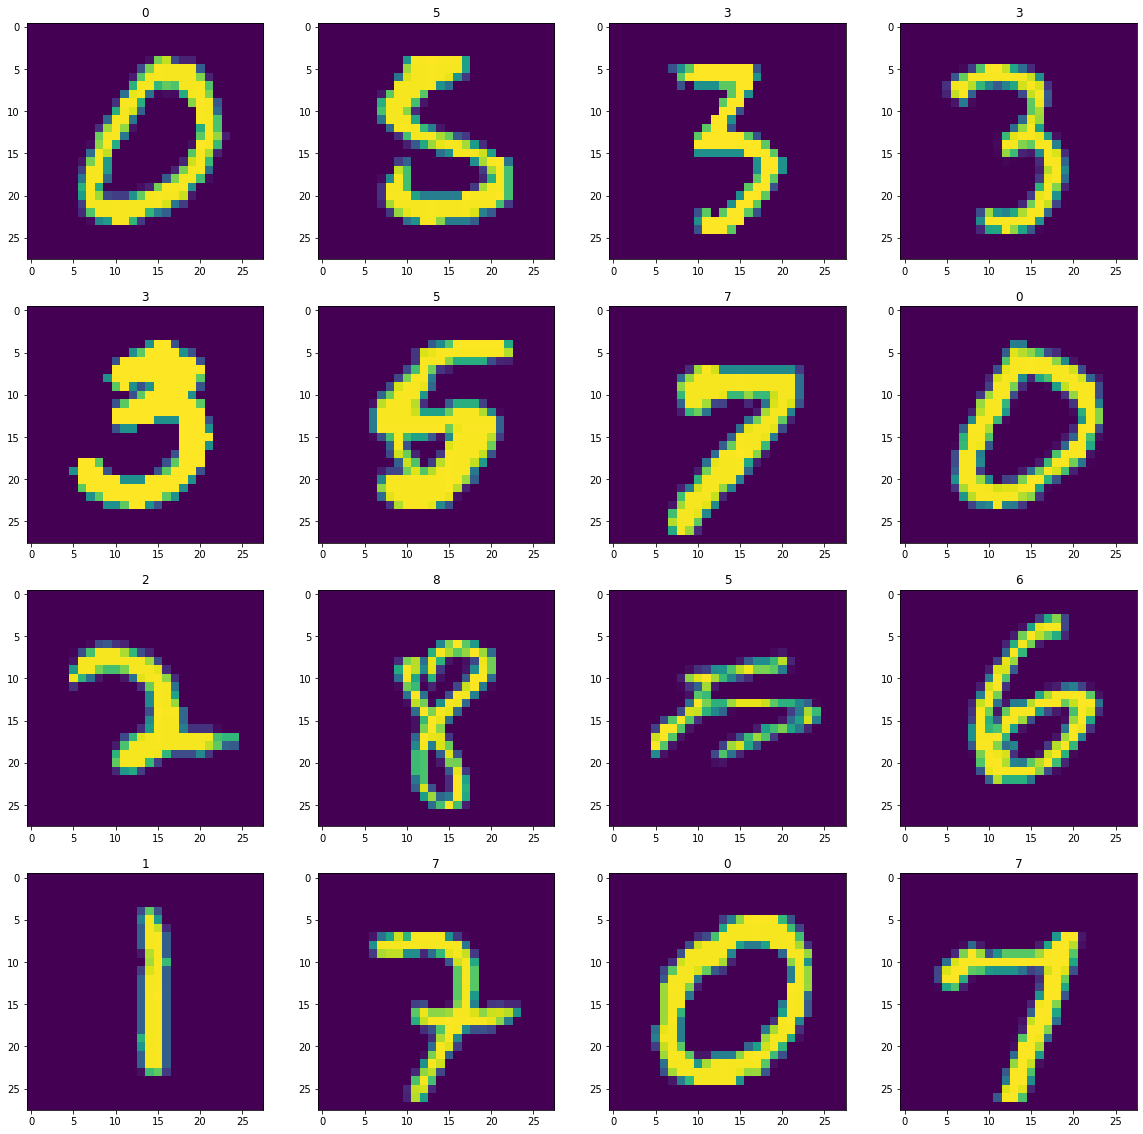

In [3]:
# display a 4x4 grid, 
# choose 16 images randomly, display the images as well as corresponding labels

f, axarr = plt.subplots(4,4, figsize=(20,20))

i = 0
j = 0
for x in range(16):
  if j>3:
    j = 0
    i += 1

  axarr[i, j].imshow(X_train[:,x].reshape(28,28));
  axarr[i, j].set_title(Y_train[x])

  j+=1

## Building up parts of our classifier

**Activation functions**

In [4]:
def relu(z):
    """
    Arguments:
    z -- A scalar or numpy array.
    Return:
    relu func applied to each element of z
    """
    return np.maximum(0,z)

def softmax(z):
    """
    returns computed probabilitites for each element in batch separately
    input: (N, 10)
    output: (N, 10)
    """
    return np.exp(z)/np.sum(np.exp(z), axis=0, keepdims=True)

**Notes about the Neural Network** 
*   Input size is (784,) because 28x28 = 784
*   Output size will be 10, each element represeting probability of the image representing that digit
*   Size of the hidden layer is a hyperparameter



**Initialize the layers weights**

Generally, we follow the convention that weights are drawn from a standard normal distribution, while the bias vectors are initialized to zero. But you can try everything out :)

In [5]:
def init_params(hidden_nodes):
    """
    ideally it should take the size of all the layers and 
    should return the initialized weights.
    """
    W1 = np.random.rand(hidden_nodes,784) - 0.5
    W2 = np.random.rand(10,hidden_nodes) - 0.5
    b1 = np.random.rand(hidden_nodes,1) - 0.5
    b2 = np.random.rand(10,1) - 0.5
    
    weights = {'W1':W1, 'W2':W2}
    biases = {'b1':b1, 'b2':b2}

    return weights, biases

**Forward Propagation**

In [6]:
def forward_propg(X, weights, biases):
    """
    X: input data
    returns: logits, output of each layer z1,z2,a1,a2
    """
    W1, W2 = weights['W1'], weights['W2']
    b1, b2 = biases['b1'], biases['b2']

    z1 = np.dot(W1, X) + b1
    a1 = relu(z1)
    z2 = np.dot(W2,a1) + b2
    a2 = softmax(z2)

    return z1, a1, z2, a2

**Backward Propagation**


You may use stochastic gradient descent or batch gradient descent here. Feel free to use any loss function.

In [7]:
def relu_deriv(z):
    return z>0

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def backward_propg(weights, biases, X, Y, z1, a1, z2, a2, lr):
    """
    should update the weights and return updated weights
    """
    loss = 1/m * (np.multiply(Y, np.log(a2)) + np.multiply(1-Y, np.log(1 - a2)))
    cost = -np.sum(loss)

    W1, W2 = weights['W1'], weights['W2']
    b1, b2 = biases['b1'], biases['b2']
    one_hot_Y = one_hot(Y)
    dz2 = a2 - one_hot_Y
    dw2 = 1/m * np.dot(dz2, a1.T)
    db2 = 1/m * np.sum(dz2, axis=1, keepdims=True)
    dz1 = np.dot(W2.T, dz2) * relu_deriv(z1)
    dw1 = 1/m * np.dot(dz1, X.T)
    db1 = 1/m * np.sum(dz1, axis=1, keepdims=True)

    W1 = W1 - lr*dw1
    b1 = b1 - lr*db1
    W2 = W2 - lr*dw2
    b2 = b2 - lr*db2

    weights = {'W1':W1, 'W2':W2}
    biases = {'b1':b1, 'b2':b2}

    return weights, biases, cost

In [8]:
def cost_func(weight,Y,params):
    """
    calculate loss to check whether it is decreasing at each epoch or not
    one can return this in backward propagation as well
    """
    pass


## Integrate everything

In [9]:
def train(X, Y, hidden_nodes, epochs=1000, lr=1e-5):
    """
    hidden_nodes: no. of nodes in hidden layer

    should return the updated optimize weights.
    """
    # initialize weights.

    weights, biases = init_params(hidden_nodes)

    for i in range(epochs):
        # forward propagation
        z1, a1, z2, a2 = forward_propg(X, weights, biases)
        # print cost at every 100 or so iterations
        # backward propagation
        weights, biases, cost = backward_propg(weights, biases, X, Y, z1, a1, z2, a2, lr)
        if i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    updated_weights = weights
    updated_biases = biases
    return updated_weights, updated_biases

In [10]:
def predict(X, updated_weights, updated_biases):
    """
    returns the prediction in [0,9] for each element in X
    """
    _, _, _, a2 = forward_propg(X, updated_weights, updated_biases)
    predictions = np.argmax(a2, 0)
    return predictions

In [11]:
def accuracy(predictions, Y):
    """
    prints % accuracy
    """
    dec = np.sum(predictions == Y) / Y.size
    print(dec * 100)

In [12]:
updated_weights, updated_biases = train(X_train, Y_train, 88, epochs=1000, lr=0.1)
predictions = predict(X_dev, updated_weights, updated_biases)
accuracy(predictions, Y_dev)

Cost after iteration 0: 562.141425
Cost after iteration 100: 686.553299
Cost after iteration 200: 778.001817
Cost after iteration 300: 823.518150
Cost after iteration 400: 853.471451
Cost after iteration 500: 876.721258
Cost after iteration 600: 896.161081
Cost after iteration 700: 912.668854
Cost after iteration 800: 927.129374
Cost after iteration 900: 940.129718
90.91666666666667


Prediction:  [5]
Label:  5


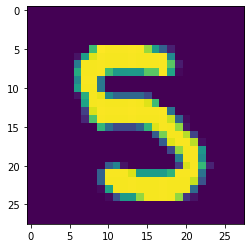

Prediction:  [8]
Label:  8


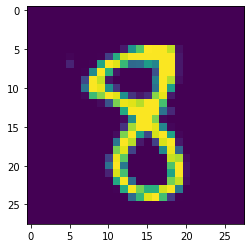

Prediction:  [5]
Label:  5


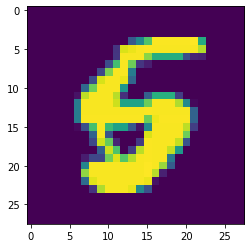

Prediction:  [7]
Label:  7


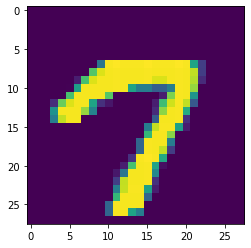

In [13]:
#Testing Predictions

def test_prediction(index, updated_weights, updated_biases):
    current_image = X_train[:, index, None]
    prediction = predict(X_train[:, index, None], updated_weights, updated_biases)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

import random
test_prediction(random.randint(0,10000), updated_weights, updated_biases)
test_prediction(random.randint(0,10000), updated_weights, updated_biases)
test_prediction(random.randint(0,10000), updated_weights, updated_biases)
test_prediction(random.randint(0,10000), updated_weights, updated_biases)

### Save as pickle

In [15]:
import pickle
import random
from google.colab import files

roll_num = "20b030020" # enter ldap
hidden_dim = 88 # replace with your own hidden dimension

model_dict = {
    'z': hidden_dim, # hidden dimension of your model
    'layer_0_wt': updated_weights['W1'].T, # layer 0 weight (784, z)
    'layer_0_bias': updated_biases['b1'], # layer 0 bias (z, 1)
    'layer_1_wt': updated_weights['W2'].T, # layer 1 weight (z, 10)
    'layer_1_bias': updated_biases['b2'] # layer 1 bias (10, 1)
}

assert model_dict['layer_0_wt'].shape == (784, hidden_dim)
assert model_dict['layer_0_bias'].shape == (hidden_dim, 1)
assert model_dict['layer_1_wt'].shape == (hidden_dim, 10)
assert model_dict['layer_1_bias'].shape == (10, 1)

with open(f'model_{roll_num}.pkl', 'wb') as f:
    pickle.dump(model_dict, f)
    files.download(f'model_{roll_num}.pkl') # download the file from the Colab session for submission

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>